# Movie recommendation on the movielens dataset
By Olga Vishnyakova (Snumber), Alice Bulonza (Snumber) and Rudo Brus (s4362276)

In this notebook the work on the small movielens dataset are shown. This notebook is ment to be complementary to the report to show how we got to our results.

This notebook has three parts, we start with the data preprocessing, then we implement the recommendation algorithms and finally we end with evaluation of those algorithms.

In [1]:
# Importing the necessary libraries for this project
import numpy as np
import pandas as pd
import os
import random
from scipy import stats
import collections
%matplotlib inline

print('These are the files present in the small movielens dataset:')
print(os.listdir("ml-latest-small"))

These are the files present in the small movielens dataset:
['links.csv', 'movies.csv', 'ratings.csv', 'README.txt', 'tags.csv']


## 1 &nbsp; &nbsp; Data preprocessing
In this part we load in the different files the dataset contains and do some feature extraction from these files.

### 1.1 &nbsp; &nbsp;  Retrieving information from the movies.csv file

In [2]:
# Reading in the movies.csv file, containg the movieID, title and genres
movie = pd.read_csv("ml-latest-small/movies.csv")
print('The movies.csv file contains {} movies with their movieID, title (Including  year) and genres').format(movie.shape[0])
display(movie.head(5))

The movies.csv file contains 9742 movies with their movieID, title (Including  year) and genres


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# Retrieving the year the movie came out from the title and giving it its own separate column
movie['year'] = movie['title'].str.extract('.*\((.*)\).*', expand=True)
movie['year'] = movie['year'].fillna(value=0)
movie['year'] = movie['year'].map(lambda x: str(x)[:4])
movie["year"] = pd.to_numeric(movie["year"])

# Showning new table
print('The datatable now also including the year the movie came out in a separate column')
display(movie.head(5))

The datatable now also including the year the movie came out in a separate column


,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [4]:
# Splitting up the genres for easier data processing. Every genre gets its separate column containing either 
# a 0 indicating it is not in that genre or a 1 indicating the movie is part of that genre.

# Showing that there are a lot of unique genre combinations, which is hard to work with
unique_genres = pd.unique(movie[['genres']].values.ravel('K'))
nr_unique_genre_combinations = unique_genres.shape[0]

# Splitting up the genres and showing the number of unique genres there are:
split_genre = [unique_genres.split('|') for unique_genres in unique_genres]
genres_set = sorted(set([item for sublist in split_genre for item in sublist]))

print('There are {} unique genres combinations, but only {} unique genres namely:'.format(nr_unique_genre_combinations, len(genres_set)))
print(genres_set)

# Helper function to seperate the genres
def match_genre(row, cur_genre):
    movie_genres = row['genres'].split('|')
    return int(cur_genre in movie_genres)

# Create the new columns for the genre with the correct binary values
for genre in genres_set:
    movie[genre] = movie.apply (lambda row: match_genre(row, genre),axis=1)

There are 951 unique genres combinations, but only 20 unique genres namely:
['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [5]:
# Deleting now useless genres column
del movie['genres']

#Displaying the new table
print('\n\n The data table now also containing the genres in seperate columns')
display(movie.head(5))



 The data table now also containing the genres in seperate columns


,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),1995,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### 1.2 &nbsp; &nbsp; Retrieving information for the ratings.csv file

The ratings.csv data containing userID, movieID and rating


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0



 Distribution of the ratings:


count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


 Histogram of the distribution of the ratings:


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000BD34358>]],
      dtype=object)

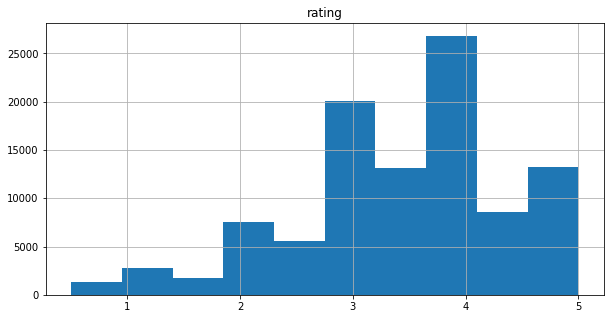

In [6]:
# Reading in the ratings.csv file and some information on what it contains

# Reading in the ratings.csv file, containg the userID, movieID, rating and timestamp
rating = pd.read_csv("ml-latest-small/ratings.csv")
# In this project we don't make use of the timestamps, so we remove that column
rating = rating.loc[:,["userId","movieId","rating"]]
# Displaying rating data table
print('The ratings.csv data containing userID, movieID and rating')
display(rating.head(5))

# Distribution of the ratings
print('\n Distribution of the ratings:')
display(rating['rating'].describe())

# Histogram of the distribution
print('\n Histogram of the distribution of the ratings:')
display(rating.hist(column='rating', figsize=(10,5)))

In [7]:
# Estimating the average rating for each movie
avg_ratings= rating.groupby('movieId', as_index=False).mean()
del avg_ratings['userId']
print('Table with movieID and average rating of movie:')
display(avg_ratings.head(5))

Table with movieID and average rating of movie:


,movieId,rating
0,1,3.920930
1,2,3.431818
2,3,3.259615
3,4,2.357143
4,5,3.071429


In [8]:
# Merging the new average rating data with the movies.csv file information
movie_content = movie.merge(avg_ratings, on='movieId', how='inner')
print('Updated movie data table now also including the average rating')
display(movie_content.head(5))

Updated movie data table now also including the average rating


,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating
0,1,Toy Story (1995),1995,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,3.920930
1,2,Jumanji (1995),1995,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3.431818
2,3,Grumpier Old Men (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,3.259615
3,4,Waiting to Exhale (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,2.357143
4,5,Father of the Bride Part II (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3.071429


### 1.3 &nbsp; &nbsp; Retrieving information from the tags.csv file

The tags.csv data containing userID, movieID and tag


,userId,movieId,tag
0,2,60756,funny
1,2,60756,Highly quotable
2,2,60756,will ferrell
3,2,89774,Boxing story
4,2,89774,MMA



 
 There are 1589 unique tags, the 20 most used are shown below


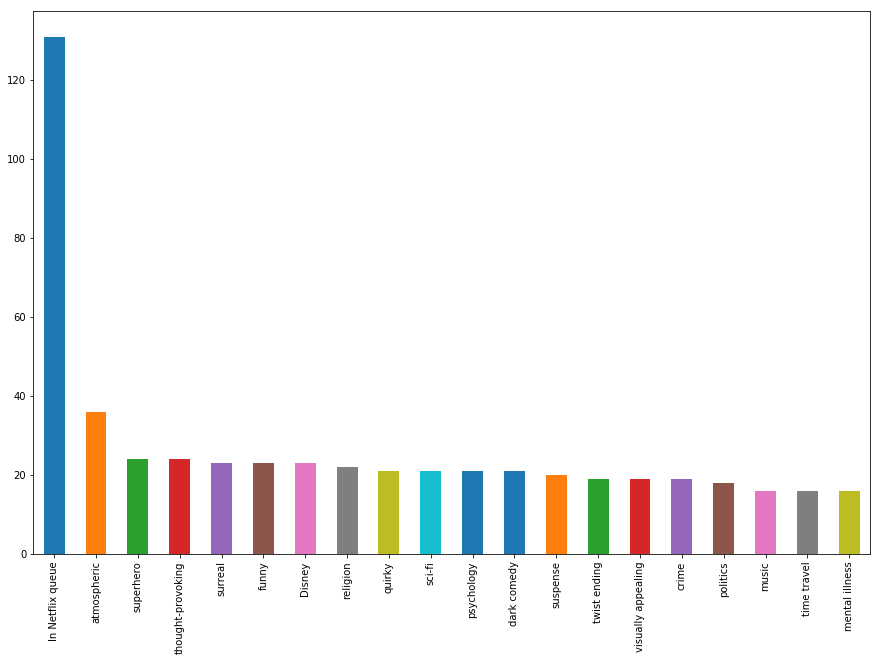

In [9]:
# Reading in the ratings.csv file and some information on what it contains

# Reading in the tags.csv file, containg the userId, movieID, tag and timestamp
tags = pd.read_csv("ml-latest-small/tags.csv")
# In this project we don't make use of the timestamps, so we remove that column
tags = tags.loc[:,["userId","movieId","tag"]]
# Displaying tags data table
print('The tags.csv data containing userID, movieID and tag')
display(tags.head(5))

# Analyzing amount of unique tags

# Getting unique tags from datatable
unique_tags = pd.unique(tags[['tag']].values.ravel('K'))
print('\n \n There are {} unique tags, the 20 most used are shown below'.format(unique_tags.shape[0]))
#print(sorted(unique_tags))

# Counting tags
tag_counts = tags['tag'].value_counts()
# Showing graph with 20 most used tags
display(tag_counts[:20].plot(kind='bar', figsize=(15,10)))

In [10]:
# Adding top nr_tags_to_add tags to movie data table
# Setting tags to be added
nr_tags_to_add = 50
tag_set = tag_counts.keys()[:nr_tags_to_add]

# Helper function
def match_tag(row, cur_tag):
    cur_movie = row['movieId'] 
    return tags.loc[(tags['movieId'] == cur_movie) & (tags['tag'] == cur_tag)].shape[0]

# create additional nr_tags_to_add features for tags for content-based analysis
for tag in tag_set:
    movie_content[tag] = movie_content.apply (lambda row: match_tag(row, tag),axis=1)
    
# Showing new movie data table
print('Final movie data table now also including the {} most used tags').format(nr_tags_to_add)
display(movie_content.head(5))

Final movie data table now also including the 50 most used tags


,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,boxing,psychological,comic book,adultery,Holocaust,adolescence,remake,cinematography,robots,philosophical
0,1,Toy Story (1995),1995,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),1995,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [11]:
# Creating pivot table of ratings for collaborative filtering, 
# replacing missing values with average rating of the movie

# Creating pivot table and showing first result
pivot_table = rating.pivot_table(index = ["userId"],columns = ["movieId"],values = "rating")
print('Pivot table containing the rating of movies for each user')
display(pivot_table.head(5))

print(' \n The pivot table has {} missing values, to try and fix these we use the average rating of a movie on the places of missing values').format(pivot_table.isnull().sum().sum())

# Filling the missing values with average value of movie
pivot_table_mean = pivot_table.fillna(pivot_table.mean())
# Showing new pivot table
print('\n \n Pivot table containing the rating of movies for each user with missing values as average rating')
display(pivot_table_mean.head(5))

Pivot table containing the rating of movies for each user


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 
 The pivot table has 5830804 missing values, to try and fix these we use the average rating of a movie on the places of missing values

 
 Pivot table containing the rating of movies for each user with missing values as average rating


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.00000,3.431818,4.000000,2.357143,3.071429,4.000000,3.185185,2.875,3.125,3.496212,...,3.5,3.0,4.0,4.0,3.5,4.0,3.5,3.5,3.5,4.0
2,3.92093,3.431818,3.259615,2.357143,3.071429,3.946078,3.185185,2.875,3.125,3.496212,...,3.5,3.0,4.0,4.0,3.5,4.0,3.5,3.5,3.5,4.0
3,3.92093,3.431818,3.259615,2.357143,3.071429,3.946078,3.185185,2.875,3.125,3.496212,...,3.5,3.0,4.0,4.0,3.5,4.0,3.5,3.5,3.5,4.0
4,3.92093,3.431818,3.259615,2.357143,3.071429,3.946078,3.185185,2.875,3.125,3.496212,...,3.5,3.0,4.0,4.0,3.5,4.0,3.5,3.5,3.5,4.0
5,4.00000,3.431818,3.259615,2.357143,3.071429,3.946078,3.185185,2.875,3.125,3.496212,...,3.5,3.0,4.0,4.0,3.5,4.0,3.5,3.5,3.5,4.0


## 2 &nbsp; &nbsp; Implementing the recommendation algorithms
Having done the data preprocessing the next step is to implement the recommendation algorithms. In this segment we will try to implement three algorithms: Content based filtering, item based collaborative filtering and user based collaborative filtering. Since all these algorithms need movies the user liked we first implement some code to get this.

In [12]:
# TODO: Other distance measure then pairwise? Play around with some parameters (Amount of user_liked_movies, 
# selection of user liked movies, amount of tags, amount of similar users/items) 
# TODO: Make hybrid filters


#Possible similarity measures:
#Cosine-Based Similarity
#Correlation-Based Similarity
#Adjusted Cosine Similarity
#1-Jaccard distance

# Problems:
# To many disney like movies "children, animation and Disney itself"
# Giving only recommendations in 1 genre
# There is a 2 for a disney movie?

# Setting th test_userId that all filters will be shown on
test_userId = 1

# First we define a function that can find the movies that are liked by an userID
#TODO: Better way of finding movies that user liked then 5 out of 5, top x, not lower then 3.5 maybe?
def get_user_liked_movies(test_userId, show_result=False):
    # Take ratings given by userId and only keep the movies he rated as a perfect 5 out of 5
    user_liked_movies = rating.loc[(rating['userId'] == test_userId) & (rating['rating'] == 5)]
    user_liked_movies = user_liked_movies['movieId'].values

    # Making sure we don't take too many movies, maybe remove after testing
    max_movies = 25
    if len(user_liked_movies)>max_movies:
        user_liked_movies = random.sample(user_liked_movies, max_movies)
    
    # Show the movies that the user likes
    if show_result == True:
        print('The {} movies the user liked and that will be used for recommendation').format(len(user_liked_movies))
        display(movie_content.iloc[user_liked_movies]['title'])
        
    return user_liked_movies

user_liked_movies = get_user_liked_movies(test_userId, show_result = True)

The 25 movies the user liked and that will be used for recommendation


1210        Hunt for Red October, The (1990)
1213                        Star Maps (1997)
2641          Filth and the Fury, The (2000)
940                             Glory (1989)
1073                  Raising Arizona (1987)
2078         Thomas Crown Affair, The (1999)
661                             Bound (1996)
1222                Thousand Acres, A (1997)
2033               Muppets From Space (1999)
1024                       Body Parts (1991)
216                              I.Q. (1994)
2529                        She-Devil (1989)
2949                Time Machine, The (1960)
1023                      Blood Beach (1981)
1240                Washington Square (1997)
1226                  MatchMaker, The (1997)
2115                      In Too Deep (1999)
1298                        Afterglow (1997)
1270                       Red Corner (1997)
2291                        Meatballs (1979)
457                    Romper Stomper (1992)
2948    Billy Jack Goes to Washington (1977)
1278      

### 2.1 &nbsp; &nbsp; Content based filtering  ( Being worked on)
Content based filtering finds movies that are similar and then recommends similar movies to the movies you have rated highly.

In [43]:
# Content based analysis for test_userId
def content_based_recommendation(test_userId, show_result=False):
    # Get movies user likes
    user_liked_movies = get_user_liked_movies(test_userId)
    
    # We don't want the movieId or title in our content based analysis, so we get these out
    # TODO: Rating is questionable to use
    movie_content_sim = movie_content.iloc[:,2:] 
    movie_content_sim = movie_content_sim.astype('float32')

    # Normalization on the data
    for col in list(movie_content_sim.columns):
        movie_content_sim[col] = (movie_content_sim[col] - movie_content_sim[col].mean())/movie_content_sim[col].std(ddof=0)

    # Calculating similarity score of user liked movies one by one and summing them up
    for i in range(len(user_liked_movies)):
        # Setting movie that similarity will be tested on
        liked_movieId = user_liked_movies[i]

        # Getting index of ther row of this movie
        indx = movie_content[movie_content['movieId']==liked_movieId].index.tolist()
        indx = indx[0]

        # Calculating similarity score 
        similarity_with_other_movies = movie_content_sim.corrwith(movie_content_sim.iloc[indx], axis=1)

        # Storing the similarity
        if i == 0:
            recommended_movies = similarity_with_other_movies
        else:
            recommended_movies = recommended_movies + similarity_with_other_movies

    # Removing movies that the users has already seen from recommendations
    # Get all locations that userId has rated
    user_seen_movies = rating.loc[(rating['userId'] == test_userId) & (np.isfinite(rating['rating']))]
    user_seen_movies = user_seen_movies['movieId'].values
    # Drop seen movies from recommendation
    recommended_movies = recommended_movies.drop(user_seen_movies)
    
    # Sorting similarity with movies
    recommended_movies = recommended_movies.sort_values(ascending=False)
    
    # Displaying 10 highest recommended movies
    if show_result == True:
        index_set =  list(recommended_movies[:10].index)
        print('Top 10 movies that are recommended by content based filtering for user {}:').format(test_userId)
        display(movie_content.iloc[index_set])

    return recommended_movies
    
recommended_movies = content_based_recommendation(test_userId, show_result = True)

Top 10 movies that are recommended by content based filtering for user 1:


,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,boxing,psychological,comic book,adultery,Holocaust,adolescence,remake,cinematography,robots,philosophical
0,1,Toy Story (1995),1995,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),1995,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
5,6,Heat (1995),1995,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,7,Sabrina (1995),1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
7,8,Tom and Huck (1995),1995,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9,Sudden Death (1995),1995,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,GoldenEye (1995),1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.2 &nbsp; &nbsp; Item based collaborative filtering
Item based collaborative filter finds movies that have been rated similarly by all the users and then recommends movies that are similar to the movies you liked.

In [46]:
# Item based collaborative filtering for test_userId

def item_based_recommendation(test_userId, show_result = False):
    # Get movies user likes
    user_liked_movies = get_user_liked_movies(test_userId)
    
    # Finding similar movies to the movies that the user liked and accumulating score
    for i in range(len(user_liked_movies)):
        # Setting movie that similarity will be tested on
        liked_movieId = user_liked_movies[i]

        # Getting row of pivot table
        liked_movie = pivot_table_mean[liked_movieId]

        # Calculating similarity score 
        similarity_with_other_movies = pivot_table_mean.corrwith(liked_movie)

        # Storing the similarity
        if i == 0:
            recommended_movies = similarity_with_other_movies
        else:
            recommended_movies = recommended_movies + similarity_with_other_movies
    
    # Removing movies that the users has already seen from recommendations
    # Get all locations that userId has rated
    user_seen_movies = rating.loc[(rating['userId'] == test_userId) & (np.isfinite(rating['rating']))]
    user_seen_movies = user_seen_movies['movieId'].values
    # Drop seen movies from recommendation
    recommended_movies = recommended_movies.drop(user_seen_movies)
    
    # Sorting similarity with movies
    recommended_movies = recommended_movies.sort_values(ascending=False)
    
    # Displaying 10 highest recommended movies
    if show_result == True:
        index_set =  list(recommended_movies[:10].index)
        print('Top 10 movies that are recommended by item based colaborative filtering for user {}:').format(test_userId)
        display(movie_content.iloc[index_set]['title'])
    
    return recommended_movies

recommended_movies = item_based_recommendation(test_userId, show_result = True)

Top 10 movies that are recommended by item based colaborative filtering for user 1:


2457                                Bad Lieutenant (1992)
1259                                     Incognito (1997)
3104                                Gray's Anatomy (1996)
1257                                 Boogie Nights (1997)
1663    Swept Away (Travolti da un insolito destino ne...
2261                                 Bachelor, The (1999)
2134                                Stir of Echoes (1999)
3505                                    Indiscreet (1958)
3040                       Amazing Grace and Chuck (1987)
555     Bloodsport 2 (a.k.a. Bloodsport II: The Next K...
Name: title, dtype: object

### 2.3 &nbsp; &nbsp; User based collaborative filtering
User based collaborative filtering finds users that have rated movies similar as you have and then recommends you the movies that you have not seen and they liked.

In [65]:
# Collaborative filtering for test_userId

def user_based_recommendation(test_userId, show_result = False):
    # Getting row of pivot table
    base_user = pivot_table_mean[test_userId]
    # Calculating similarity score 
    similarity_with_other_users = pivot_table_mean.corrwith(base_user, axis=1)
    # Storing the similarity
    similar_users = similarity_with_other_users
    # Sorting similarity with other users
    similar_users = similar_users.sort_values(ascending=False)
    # Only keeping the 500 most similar users
    similar_users = similar_users[:250].index


    # Initializing empty array for recommended movies
    recommended_movies = []

    # Recommending similar users movies that similar users have liked
    for i in range(len(similar_users)):
        # Take ratings given by userId and only keep the movies he rated as a perfect 5 out of 5  (What to keep is easily adjusted)
        user_liked_movies = rating.loc[(rating['userId'] == similar_users[i]) & (rating['rating'] == 5)]
        user_liked_movies = user_liked_movies['movieId'].values

        # Storing the similar user liked movies
        recommended_movies.extend(user_liked_movies)

    # Counting the times movies are watched by similar users and sorting them
    cnt = collections.Counter(recommended_movies)
    recommended_movies = cnt.most_common()
    recommended_movies = [seq[0] for seq in recommended_movies]
    
    # Removing movies that the users has already seen from recommendations
    # Get all locations that userId has rated
    user_seen_movies = rating.loc[(rating['userId'] == test_userId) & (np.isfinite(rating['rating']))]
    user_seen_movies = user_seen_movies['movieId'].values

    # Drop seen movies from recommendation
    recommended_movies = [movie for movie in recommended_movies if movie not in (user_seen_movies)]
    
    # Displaying 10 most often liked movies by similar users
    if show_result == True:
        print('Top 10 movies that are recommended by user based colaborative filtering for user {}:').format(test_userId)
        display(movie_content.iloc[recommended_movies[:10]]['title'])
    return recommended_movies

recommended_movies = user_based_recommendation(test_userId, show_result = True)

Top 10 movies that are recommended by user based colaborative filtering for user 1:


318                         I Love Trouble (1994)
858                           Howling, The (1980)
589                             Last Dance (1996)
364                  Beverly Hills Cop III (1994)
4993                               Matinee (1993)
7153    Aelita: The Queen of Mars (Aelita) (1924)
588                  Great White Hype, The (1996)
5952                                  Duma (2005)
595                              Barb Wire (1996)
1221                            Wishmaster (1997)
Name: title, dtype: object

## 3 &nbsp; &nbsp; Evaluating the recommendation algorithms
In this section we will evaluate the different recommendation systems and their results. 

In [16]:
# Problems:
# No usage of timestamps, would be better to simulate "online" data
# Lots of movies to recommend, could be that he/she would actually like other movies better, but should atleast not be very low
# Person that has not liked a lot of movies is hard to leave out data from
# Do this for how many persons and leave out how much data?
# Could be accurate predicition but person just has not seen movie yet, problem with precision/recall not with actual rating

# Sample test users, hide some data and sample those out of our recommendation system

# RMSE of MAE implementeren? Dan heb ik echt ratings nodig en niet "hoog/laag"

# Precision and recall might be easier, look at top +- 100 predictions and calculate precision and recall of those
# Thus amount of relevant movies recommended/recommended items and relevant movies/relevant items, define relevant 
# as movies rated higher then 3.5?

### 3.1 &nbsp; &nbsp; Comparison of non-hybrid recommendation systems

In [17]:
# Leave some of the data of testuser out (some of the movies he has rated as 5 out of 5)
total_users = len(pivot_table.index)

# We will be testing on 20% of the users
test_users = np.random.permutation(np.arange(1,total_users+1))[:int(round(0.2 * total_users))]

# Test with 5 users first as a test
test_users = np.arange(1,6)

# Recommend movies for every user, calculate precision and recall (first with only 5's as relevant), 
# do this for collaborative and others

content_recommendation = []
item_recommendation = []
user_recommendation = []

for i in range(len(test_users)):
    np.append(content_recommendation, content_based_recommendation(test_users[i]))
    np.append(item_recommendation, item_based_recommendation(test_users[i]))
    np.append(user_recommendation, user_based_recommendation(test_users[i]))

print(content_recommendation)

[]


### 3.2 &nbsp; &nbsp; Comparison of hybrid recommendation systems

### 3.3 &nbsp; &nbsp; Complete comparison

# End

## Example from Olga for Rudo to help with implementing filters (Creates a cosine matrix of similaraties which is the pairwise distances between two items)

In [18]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation

movie_similarity_by_ratings = 1 - pairwise_distances(pivot_table.as_matrix(), metric="cosine")
np.fill_diagonal(movie_similarity_by_ratings, 0 ) 
# ratings_matrix = pd.DataFrame( movie_similarity )

D:\ProgramFiles\Anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
movie_similarity_by_ratings.shape